# Práctica I

## Extracción de los datos

### Funciones de utilidad

Se crea una función que permite extrare el data frame a partir del código del juego de datos

In [354]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import requests, json

In [355]:


def get_raw_data_frame( key, gziped ): 
    
    # url_template = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/%s$DEFAULTVIEW/?format=TSV&compressed=false' 
    
    url_template =  'https://ec.europa.eu/eurostat/databrowser-backend/api/extraction/1.0/LIVE/false/tsv/%s?i'

    url = url_template % key

    return pd.read_table( url, compression = 'gzip' ) if gziped else  pd.read_table(  url )


Extraer el país a partir de la primera columna del dataframe

In [356]:
def extract_country( data ):
    
    new_data = data.rename( columns={data.iloc[:, 0].name :'country'} )

    new_data['country'] = new_data['country'].str.replace(r'^.*,(.*)$', r'\1', regex=True)
    
    return new_data


Eliminar espacios en los nombres de las columnas

In [357]:
def trim_column_names( data ):
    
    for col in data.columns:
    
        data = data.rename( columns={col :col.strip()} )
    
    return data
    

Limpia, trata y transforma todas las columnas que son númericas

In [358]:
def clean_numeric_columns( data ):
   
   data.iloc[:,1:] = data.iloc[:,1:].replace(
        r'^.*[:].*$', None, regex=True # Not available and confidencial flag
   ).replace(
        r'e', '', regex=True # Remove flag estimated
   ).replace(
        r'd', '', regex=True # Remove flag definition differs
   ).replace( 
        r'^(.+) +$', r'\1', regex = True # rTrim
   ).replace( 
        r'^ +(.+)$', r'\1', regex = True # lTrim>
   )
   
   for col in  data.iloc[:,1:].columns :    
        data[col] = pd.to_numeric( data[col] )
    
   return data
    
    

Función que filtra los valores por el filtro

In [359]:
def filter_data( filter ): 
    def _filter_data( data ):
        new_data = data[data.iloc[:, 0].str.contains( filter )]    
        new_data.reset_index(inplace = True, drop = True)
        return new_data
    return _filter_data
    

Función que obtiene el maestro de países, que permite obtener el nombre del país a partir de su identificador

In [360]:
def get_country_names():
    url = requests.get("https://ec.europa.eu/eurostat/databrowser-backend/api/codelist/LIVE/GEO/getCodeListJson/9.0/ESTAT/en/false")
    text = url.text
    data = json.loads(text)
    return data['category']['label']

Función que añade la columna con el nombre de los países

In [361]:
def add_column_country_name_flow():    
    
    def _add_column_country_name(data) : 
        country_names = get_country_names()    
        data.insert(
            1, 
            'country_name', 
            data.country.map(lambda v: country_names[v] ), 
            True
        )
        return data
    
    return _add_column_country_name 

Función que realiza todo el proceso de extración y limpieza de los datos

In [362]:
class Compose:
    _f = None
    def __init__(self, f):
        self._f = f
    def andThen( self, g ):
        return Compose( lambda s: ( g( self._f(s) ) ) )
    def apply(self, a): 
        return self._f( a )
    
column_country_name = add_column_country_name_flow()    

def flow( filter ) :
    return Compose( 
        filter_data( filter )
    ).andThen(
        extract_country
    ).andThen(
        trim_column_names 
    ).andThen( 
        clean_numeric_columns 
    ).andThen( 
        column_country_name
    )

def dataframe_by_key( key, filter, gziped = False ):
        return flow(filter).apply(  get_raw_data_frame( key, gziped ) )


Función que permite exportar el dataframe a fichero CSV

In [363]:
def export_dataframe( df, name ):
    file = 'C:\Python_Projects\TipologiaYCicloDeVidaDelDato\Data\%s.csv' % name
    df.to_csv(file )
    
    

### _DATASET I_: Precio de Gas doméstico en € por kw/h

Obtenido del origen de datos [Gas prices components for household consumers - annual data](https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_202_c/default/table?lang=en)

Clave de identificación de los datos: **`NRG_PC_202_C`**

Se filtrarán los datos por:

 - Datos anuales
 - Componentes del precio de la energia: _"Energia y suministro "_
 - Consumición de la energía: En Giga Julios en todas las bandas
 - Moneda: Euro (€)
 - Unidad de medida: Kiolwatio-hora

In [364]:
data_gas_prices_household_consumers = dataframe_by_key( 
    key    = 'NRG_PC_202_C', 
    filter = 'A,NRG_SUP,TOT_GJ,EUR,KWH'
) 

Columnas del dataset:

In [365]:
display( data_gas_prices_household_consumers.dtypes )

country          object
country_name     object
2017            float64
2018            float64
2019            float64
2020            float64
2021            float64
dtype: object

Ejemplo de valores:

In [366]:
data_gas_prices_household_consumers.head(10)

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,0.0299,0.0304,0.0312,0.0308,0.0316
1,BA,Bosnia and Herzegovina,0.0240,0.0240,0.0249,0.0258,NaN
2,BE,Belgium,0.0283,0.0288,0.0289,0.0252,0.0315
3,BG,Bulgaria,0.0170,0.0209,0.0240,0.0177,0.0331
4,CZ,Czechia,0.0360,0.0390,0.0455,0.0431,0.0448
5,DE,Germany (until 1990 former territory of the FRG),NaN,NaN,0.0278,0.0292,0.0293
6,DK,Denmark,0.0234,0.0259,0.0209,0.0160,0.0415
7,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0295,0.0303,0.0319,0.0302,NaN
8,EE,Estonia,0.0234,0.0239,0.0253,0.0240,0.0361
9,EL,Greece,NaN,0.0311,0.0338,0.0258,NaN


Exportación del dataframe

In [367]:
export_dataframe( data_gas_prices_household_consumers, 'data_gas_prices_household_consumers' ) 

### _DATASET II_: Precio de Gas no doméstico en € por kw/h

Obtenido del origen de datos [Gas prices components for non-household consumers - annual data](https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_203_c/default/table?lang=en)

Clave de identificación de los datos: **`NRG_PC_203_C`**

Se filtrarán los datos por:

 - Datos anuales
 - Componentes del precio de la energia: _"Energia y suministro "_
 - Consumición de la energía: En Giga Julios en todas las bandas
 - Moneda: Euro (€)
 - Unidad de medida: Kiolwatio-hora

In [368]:
data_gas_prices_no_household_consumers = dataframe_by_key( 
    key    = 'NRG_PC_203_C', 
    filter = 'A,NRG_SUP,TOT_GJ,EUR,KWH'
) 

Columnas del dataset:

In [369]:
display( data_gas_prices_no_household_consumers.dtypes )

country          object
country_name     object
2017            float64
2018            float64
2019            float64
2020            float64
2021            float64
dtype: object

Ejemplo de valores:

In [370]:
data_gas_prices_no_household_consumers.head(10)

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,NaN,NaN,0.0184,0.0168,0.0297
1,BA,Bosnia and Herzegovina,NaN,NaN,0.0257,0.0259,0.0248
2,BE,Belgium,NaN,NaN,0.0189,0.0148,0.0318
3,BG,Bulgaria,NaN,NaN,0.0213,0.0142,0.0299
4,CZ,Czechia,NaN,NaN,0.0226,0.0192,NaN
5,DE,Germany (until 1990 former territory of the FRG),NaN,NaN,0.0196,0.0171,0.0262
6,DK,Denmark,0.0194,0.0234,0.0178,0.0137,0.0448
7,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0220,0.0240,0.0211,0.0175,NaN
8,EE,Estonia,NaN,NaN,0.0213,0.0155,0.0352
9,EL,Greece,NaN,NaN,0.0260,0.0165,NaN


Exportación del dataframe

In [371]:
export_dataframe( data_gas_prices_no_household_consumers, 'data_gas_prices_no_household_consumers' ) 

### _DATASET III_: Precio de la electricidad doméstica para la franja de 2.500 a 4.999 kWh

Obtenido del origen de datos [Electricity prices components for household consumers - annual data (from 2007 onwards)](https://ec.europa.eu/eurostat/databrowser/view/NRG_PC_204_C__custom_2388428/default/table?lang=en)

Clave de identificación de los datos: **`NRG_PC_204_C__custom_2388428`**

Se filtrarán los datos por:

 - Datos anuales
 - Consumición de la energía: Consumición entre 2500 kWh y 4999 kWh
 - Componentes del precio de la energia: _"Energia y suministro "_
 - Moneda: Euro (€)

In [372]:
data_electricity_prices_household_consumers = dataframe_by_key( 
    key    = 'NRG_PC_204_C__custom_2388428', 
    filter = 'A,KWH2500-4999,NRG_SUP,EUR', 
    gziped = True 
) 

Columnas del dataset:

In [373]:
display( data_electricity_prices_household_consumers.dtypes )

country          object
country_name     object
2012-S2         float64
2013-S2         float64
2014-S2         float64
2015-S2         float64
2016-S2         float64
2017            float64
2018            float64
2019            float64
2020            float64
2021            float64
dtype: object

Ejemplo de valores:

In [374]:
data_electricity_prices_household_consumers.head(10)

,country,country_name,2012-S2,2013-S2,2014-S2,2015-S2,2016-S2,2017,2018,2019,2020,2021
0,AL,Albania,NaN,NaN,NaN,NaN,NaN,0.0713,0.0759,0.0778,NaN,NaN
1,AT,Austria,NaN,NaN,NaN,NaN,NaN,0.0613,0.0623,0.0687,0.0732,0.0745
2,BA,Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,0.0342,0.0338,0.0361,0.0365,NaN
3,BE,Belgium,NaN,NaN,NaN,NaN,NaN,0.0735,0.0808,0.0859,0.0786,0.0844
4,BG,Bulgaria,NaN,NaN,NaN,NaN,NaN,0.0575,0.0585,0.0558,0.0560,0.0608
5,CY,Cyprus,NaN,NaN,NaN,NaN,NaN,0.1036,0.1157,0.1241,0.1042,0.1094
6,CZ,Czechia,NaN,NaN,NaN,NaN,NaN,0.0541,0.0570,0.0690,0.0749,0.0979
7,DE,Germany (until 1990 former territory of the FRG),NaN,NaN,NaN,NaN,NaN,0.0686,0.0622,0.0581,0.0574,0.0803
8,DK,Denmark,NaN,NaN,NaN,NaN,NaN,0.0388,0.0503,0.0539,0.0409,0.0747
9,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",NaN,NaN,NaN,NaN,NaN,0.0760,0.0801,0.0727,0.0697,NaN


Exportación del dataframe

In [375]:
export_dataframe( data_electricity_prices_household_consumers, 'data_electricity_prices_household_consumers' ) 

### _DATASET IV_: Precio de la electricidad no doméstica

Obtenido del origen de datos [Electricity prices components for non-household consumers - annual data (from 2007 onwards)](https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_205_c/default/table?lang=en)

Clave de identificación de los datos: **`NRG_PC_205_C`**

Se filtrarán los datos por:

 - Datos anuales
 - Componentes del precio de la energia: _"Energia y suministro "_
 - Consumición de la energía: Consumición menos de 20 MWh 
 - Moneda: Euro (€)

In [376]:
data_electricity_prices_no_household_consumers = dataframe_by_key(
    key    = 'NRG_PC_205_C', 
    filter = 'A,NRG_SUP,MWH_LT20,EUR'
) 

Columnas del dataset:

In [377]:
display( data_electricity_prices_no_household_consumers.dtypes )

country          object
country_name     object
2007-S2         float64
2008-S2         float64
2009-S2         float64
2010-S2         float64
2011-S2         float64
2012-S2         float64
2013-S2         float64
2014-S2         float64
2015-S2         float64
2016-S2         float64
2017            float64
2018            float64
2019            float64
2020            float64
2021            float64
dtype: object

Ejemplo de valores:

In [378]:
data_electricity_prices_no_household_consumers.head(10)

,country,country_name,2007-S2,2008-S2,2009-S2,2010-S2,2011-S2,2012-S2,2013-S2,2014-S2,2015-S2,2016-S2,2017,2018,2019,2020,2021
0,AT,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0598,0.0610,0.0654,0.0702,0.0723
1,BA,Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0649,0.0621,0.0624,0.0648,NaN
2,BE,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0672,0.0624,0.0663,0.0745,0.0890
3,BG,Bulgaria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0817,0.0810,0.0764,0.0730,0.1075
4,CY,Cyprus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1187,0.1240,0.1271,0.1055,0.1136
5,CZ,Czechia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0580,0.0602,0.0721,0.0811,0.0848
6,DE,Germany (until 1990 former territory of the FRG),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0468,0.0612,0.0525,0.0651,0.0707
7,DK,Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0433,0.0514,0.0517,0.0426,0.0898
8,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0757,0.0837,0.0794,0.0780,NaN
9,EE,Estonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0406,0.0489,0.0516,0.0440,0.0850


Exportación del dataframe

In [379]:
export_dataframe( 
    data_electricity_prices_no_household_consumers, 
    'data_electricity_prices_no_household_consumers' 
) 

#### Limpiamos y asignamos variables de trabajo, usamos UpperCamelCase


##### Electricidad

###### Familiar

###### Sustituimos NaN values por su media

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,0.02990,0.03040,0.0312,0.0308,0.03160
1,BA,Bosnia and Herzegovina,0.02400,0.02400,0.0249,0.0258,0.02555
2,BE,Belgium,0.02830,0.02880,0.0289,0.0252,0.03150
3,BG,Bulgaria,0.01700,0.02090,0.0240,0.0177,0.03310
4,CZ,Czechia,0.03600,0.03900,0.0455,0.0431,0.04480
5,DE,Germany (until 1990 former territory of the FRG),0.02555,0.02555,0.0278,0.0292,0.02930
6,DK,Denmark,0.02340,0.02590,0.0209,0.0160,0.04150
7,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.02950,0.03030,0.0319,0.0302,0.02555
8,EE,Estonia,0.02340,0.02390,0.0253,0.0240,0.03610
9,EL,Greece,0.02555,0.03110,0.0338,0.0258,0.02555


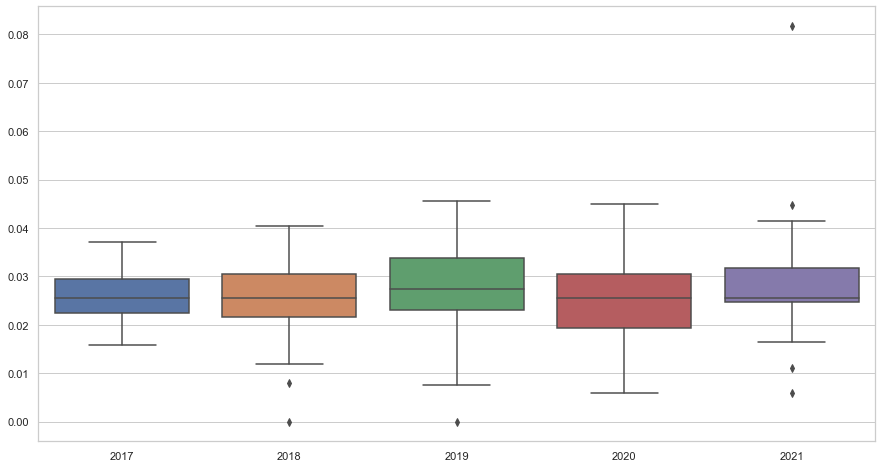

In [380]:
GasPricesHousehold=data_gas_prices_household_consumers

median = GasPricesHousehold.loc[GasPricesHousehold['2020']<1, '2020'].median()
GasPricesHousehold.fillna(median,inplace=True)

median = GasPricesHousehold.loc[GasPricesHousehold['2019']<1, '2019'].median()
GasPricesHousehold.fillna(median,inplace=True)

median = GasPricesHousehold.loc[GasPricesHousehold['2018']<1, '2018'].median()
GasPricesHousehold.fillna(median,inplace=True)

median = GasPricesHousehold.loc[GasPricesHousehold['2017']<1, '2017'].median()
GasPricesHousehold.fillna(median,inplace=True)

display(GasPricesHousehold.head(10))

sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=GasPricesHousehold)

###### Profesional

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,0.0168,0.0168,0.0184,0.0168,0.0297
1,BA,Bosnia and Herzegovina,0.0168,0.0168,0.0257,0.0259,0.0248
2,BE,Belgium,0.0168,0.0168,0.0189,0.0148,0.0318
3,BG,Bulgaria,0.0168,0.0168,0.0213,0.0142,0.0299
4,CZ,Czechia,0.0168,0.0168,0.0226,0.0192,0.0168
5,DE,Germany (until 1990 former territory of the FRG),0.0168,0.0168,0.0196,0.0171,0.0262
6,DK,Denmark,0.0194,0.0234,0.0178,0.0137,0.0448
7,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0220,0.0240,0.0211,0.0175,0.0168
8,EE,Estonia,0.0168,0.0168,0.0213,0.0155,0.0352
9,EL,Greece,0.0168,0.0168,0.0260,0.0165,0.0168


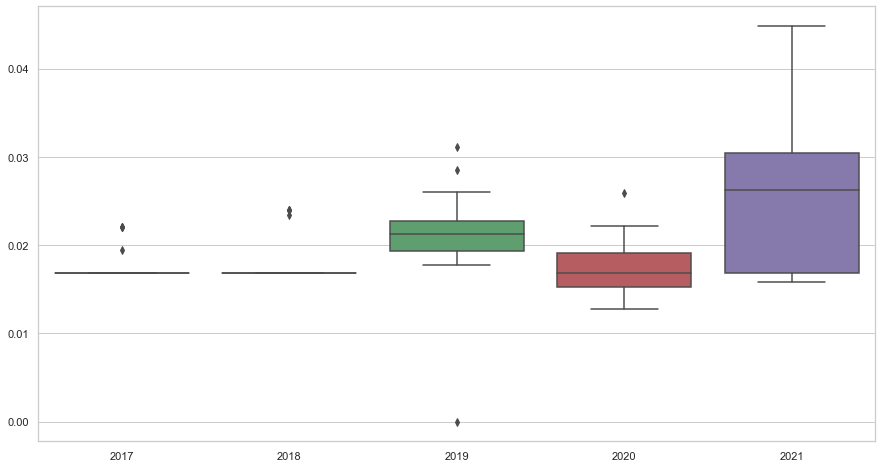

In [381]:
GasPricesNoHousehold=data_gas_prices_no_household_consumers

median = GasPricesNoHousehold.loc[GasPricesNoHousehold['2020']<1, '2020'].median()
GasPricesNoHousehold.fillna(median,inplace=True)

median = GasPricesNoHousehold.loc[GasPricesNoHousehold['2019']<1, '2019'].median()
GasPricesNoHousehold.fillna(median,inplace=True)

median = GasPricesNoHousehold.loc[GasPricesNoHousehold['2018']<1, '2018'].median()
GasPricesNoHousehold.fillna(median,inplace=True)

median = GasPricesNoHousehold.loc[GasPricesNoHousehold['2017']<1, '2017'].median()
GasPricesNoHousehold.fillna(median,inplace=True)

display(GasPricesNoHousehold.head(10))

sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=GasPricesNoHousehold)

,country,country_name,2017,2018,2019,2020,2021
0,AL,Albania,0.0713,0.0759,0.0778,NaN,NaN
1,AT,Austria,0.0613,0.0623,0.0687,0.0732,0.0745
2,BA,Bosnia and Herzegovina,0.0342,0.0338,0.0361,0.0365,NaN
3,BE,Belgium,0.0735,0.0808,0.0859,0.0786,0.0844
4,BG,Bulgaria,0.0575,0.0585,0.0558,0.0560,0.0608
5,CY,Cyprus,0.1036,0.1157,0.1241,0.1042,0.1094
6,CZ,Czechia,0.0541,0.0570,0.0690,0.0749,0.0979
7,DE,Germany (until 1990 former territory of the FRG),0.0686,0.0622,0.0581,0.0574,0.0803
8,DK,Denmark,0.0388,0.0503,0.0539,0.0409,0.0747
9,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0760,0.0801,0.0727,0.0697,NaN


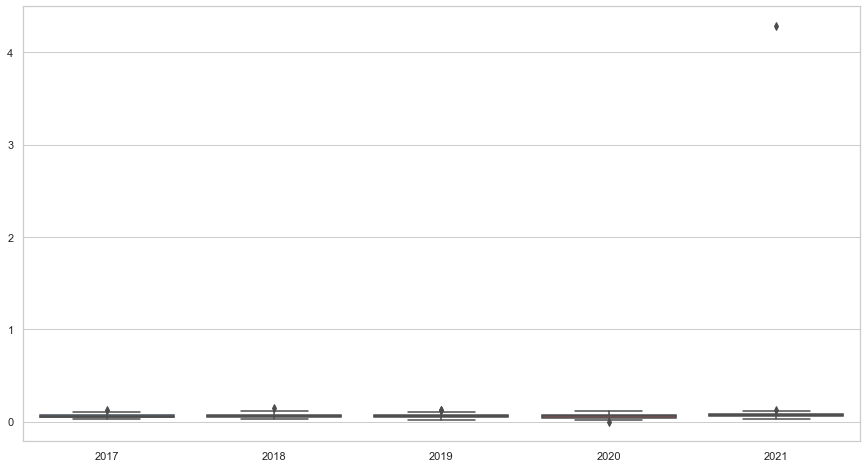

In [382]:
ElectPricesHouseholds=data_electricity_prices_household_consumers.drop(['2012-S2','2013-S2','2014-S2','2015-S2','2016-S2'], axis=1)
display(ElectPricesHouseholds.head(10))
#
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=ElectPricesHouseholds)

###### Detectamos Outlier y Nans, lo sustituimos por la media en cada caso

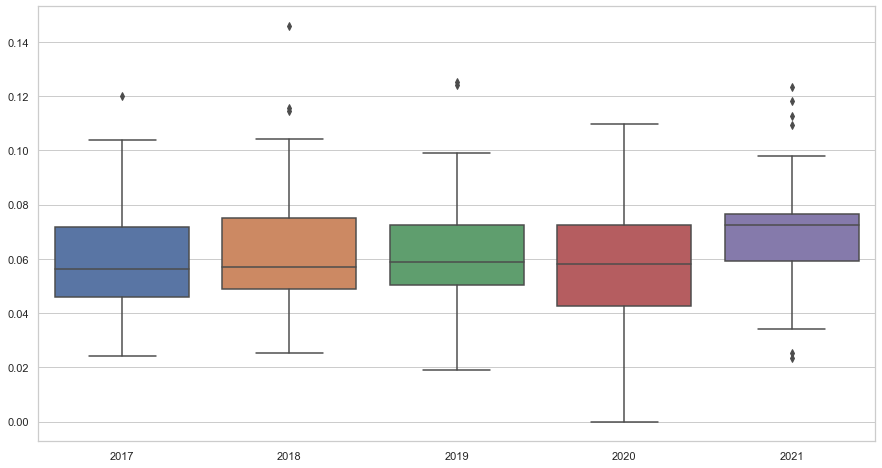

In [383]:
median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2021']<1, '2021'].median()
ElectPricesHouseholds.loc[ElectPricesHouseholds['2021'] > 1, '2021'] = np.nan
ElectPricesHouseholds.fillna(median,inplace=True)

median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2020']<1, '2020'].median()
ElectPricesHouseholds.fillna(median,inplace=True)

median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2019']<1, '2019'].median()
ElectPricesHouseholds.fillna(median,inplace=True)

median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2018']<1, '2018'].median()
ElectPricesHouseholds.fillna(median,inplace=True)

median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2017']<1, '2017'].median()
ElectPricesHouseholds.fillna(median,inplace=True)

ax = sns.boxplot(data=ElectPricesHouseholds)

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,0.0598,0.0610,0.0654,0.0702,0.0723
1,BA,Bosnia and Herzegovina,0.0649,0.0621,0.0624,0.0648,NaN
2,BE,Belgium,0.0672,0.0624,0.0663,0.0745,0.0890
3,BG,Bulgaria,0.0817,0.0810,0.0764,0.0730,0.1075
4,CY,Cyprus,0.1187,0.1240,0.1271,0.1055,0.1136
5,CZ,Czechia,0.0580,0.0602,0.0721,0.0811,0.0848
6,DE,Germany (until 1990 former territory of the FRG),0.0468,0.0612,0.0525,0.0651,0.0707
7,DK,Denmark,0.0433,0.0514,0.0517,0.0426,0.0898
8,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0757,0.0837,0.0794,0.0780,NaN
9,EE,Estonia,0.0406,0.0489,0.0516,0.0440,0.0850


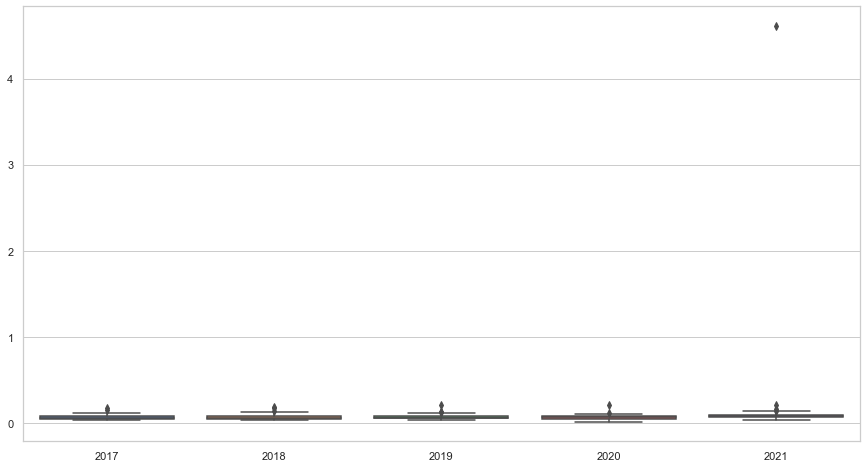

In [384]:
ElectPricesNoHouseholds=data_electricity_prices_no_household_consumers.drop(['2007-S2','2008-S2','2009-S2','2010-S2','2011-S2','2012-S2','2013-S2','2014-S2','2015-S2','2016-S2'], axis=1)
display(ElectPricesNoHouseholds.head(10))
#
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=ElectPricesNoHouseholds)

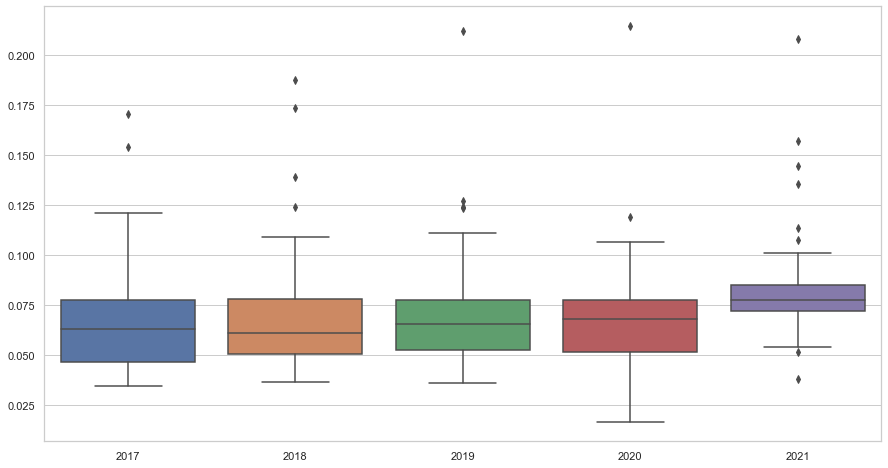

In [385]:
median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2021']<1, '2021'].median()
ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2021'] > 1, '2021'] = np.nan
ElectPricesNoHouseholds.fillna(median,inplace=True)

median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2020']<1, '2020'].median()
ElectPricesNoHouseholds.fillna(median,inplace=True)

median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2019']<1, '2019'].median()
ElectPricesNoHouseholds.fillna(median,inplace=True)

median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2018']<1, '2018'].median()
ElectPricesNoHouseholds.fillna(median,inplace=True)

median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2017']<1, '2017'].median()
ElectPricesNoHouseholds.fillna(median,inplace=True)

ax = sns.boxplot(data=ElectPricesNoHouseholds)

##### _Conclusión de análisis inicial de datos:_
Descartamos continuar el análisis de House Hold, ya que los datsets obtenidos contienen una muestra demasiada pequeña para "Gas".

### Generamos Dataset Final de trabajo

Construimos un Dataset Final con los precio de Gas y Electricidad desde 2017 hasta 2021, una vez se han arreglado los datos y se ha descartado el de No House Hold (Profesional)

In [386]:
ElectPricesHouseholds=ElectPricesHouseholds.rename(columns={"2017": "2017_ElectHouse", "2018": "2018_ElectHouse", "2019": "2019_ElectHouse", "2020": "2020_ElectHouse", "2021": "2021_ElectHouse"})
GasPricesHousehold=GasPricesHousehold.rename(columns={"2017": "2017_GasHouse", "2018": "2018_GasHouse", "2019": "2019_GasHouse", "2020": "2020_GasHouse", "2021": "2021_GasHouse"})
ElectPricesHouseholds=ElectPricesHouseholds.drop(['country_name'], axis=1)
GasPricesHousehold=GasPricesHousehold.drop(['country_name'], axis=1)
dEnergyHouseCol=pd.merge(ElectPricesHouseholds, GasPricesHousehold, on='country')
dEnergyHouseCol.head(40)

,country,2017_ElectHouse,2018_ElectHouse,2019_ElectHouse,2020_ElectHouse,2021_ElectHouse,2017_GasHouse,2018_GasHouse,2019_GasHouse,2020_GasHouse,2021_GasHouse
0,AT,0.06130,0.06230,0.06870,0.07320,0.07450,0.02990,0.03040,0.0312,0.03080,0.03160
1,BA,0.03420,0.03380,0.03610,0.03650,0.07255,0.02400,0.02400,0.0249,0.02580,0.02555
2,BE,0.07350,0.08080,0.08590,0.07860,0.08440,0.02830,0.02880,0.0289,0.02520,0.03150
3,BG,0.05750,0.05850,0.05580,0.05600,0.06080,0.01700,0.02090,0.0240,0.01770,0.03310
4,CZ,0.05410,0.05700,0.06900,0.07490,0.09790,0.03600,0.03900,0.0455,0.04310,0.04480
5,DE,0.06860,0.06220,0.05810,0.05740,0.08030,0.02555,0.02555,0.0278,0.02920,0.02930
6,DK,0.03880,0.05030,0.05390,0.04090,0.07470,0.02340,0.02590,0.0209,0.01600,0.04150
7,EA,0.07600,0.08010,0.07270,0.06970,0.07255,0.02950,0.03030,0.0319,0.03020,0.02555
8,EE,0.04420,0.05180,0.05330,0.04440,0.07640,0.02340,0.02390,0.0253,0.02400,0.03610
9,EL,0.08400,0.08630,0.09000,0.10210,0.11820,0.02555,0.03110,0.0338,0.02580,0.02555


##### Eliminamos el valor "EU27_2020"

In [387]:
dEnergyHouseTemp = dEnergyHouseCol.loc[(dEnergyHouseCol["country"] != "EU27_2020")]

### Total de Coste de Tipo de Energía por paises en los 4 últimos años

<AxesSubplot:xlabel='country', ylabel='Price'>

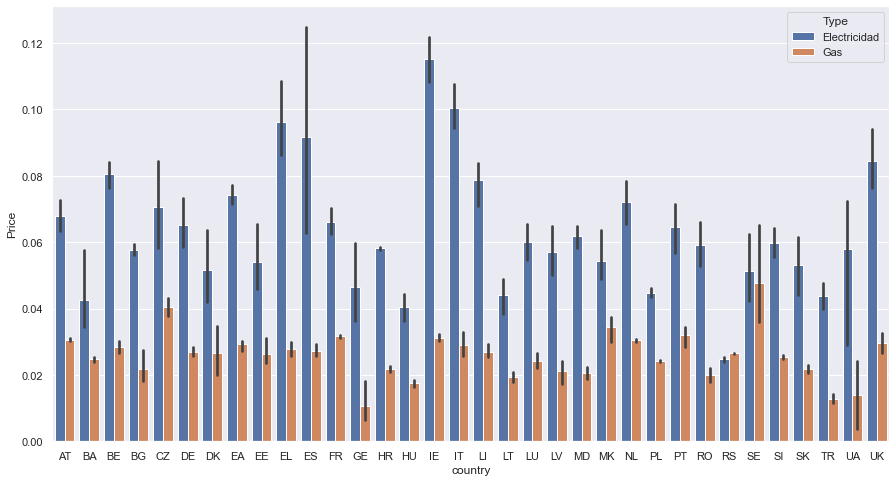

In [388]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x='country', y='Price', hue='Type', data=dEnergyHouse, saturation=0.8)


##### Trasponemos y recreamos el dataset para prepararlo para una nueva presentación multivariable

In [389]:
dEnergyHouseDummy_2017=  dEnergyHouseTemp.loc[:,['country', '2017_ElectHouse']]
dEnergyHouseDummy_2017['Year']=2017
dEnergyHouseDummy_2017['Type']='Electricidad'
dEnergyHouseDummy_2018=  dEnergyHouseTemp.loc[:,['country', '2018_ElectHouse']]
dEnergyHouseDummy_2018['Year']=2018
dEnergyHouseDummy_2018['Type']='Electricidad'
dEnergyHouseDummy_2019=  dEnergyHouseTemp.loc[:,['country', '2019_ElectHouse']]
dEnergyHouseDummy_2019['Year']=2019
dEnergyHouseDummy_2019['Type']='Electricidad'
dEnergyHouseDummy_2020=  dEnergyHouseTemp.loc[:,['country', '2020_ElectHouse']]
dEnergyHouseDummy_2020['Year']=2020
dEnergyHouseDummy_2020['Type']='Electricidad'
dEnergyHouseDummy_2021= dEnergyHouseTemp.loc[:,['country', '2021_ElectHouse']]
dEnergyHouseDummy_2021['Year']=2021
dEnergyHouseDummy_2021['Type']='Electricidad'

dGasHouseDummy_2017=  dEnergyHouseTemp.loc[:,['country', '2017_GasHouse']]
dGasHouseDummy_2017['Year']=2017
dGasHouseDummy_2017['Type']='Gas'
dGasHouseDummy_2018=  dEnergyHouseTemp.loc[:,['country', '2018_GasHouse']]
dGasHouseDummy_2018['Year']=2018
dGasHouseDummy_2018['Type']='Gas'
dGasHouseDummy_2019=  dEnergyHouseTemp.loc[:,['country', '2019_GasHouse']]
dGasHouseDummy_2019['Year']=2019
dGasHouseDummy_2019['Type']='Gas'
dGasHouseDummy_2020=  dEnergyHouseTemp.loc[:,['country', '2020_GasHouse']]
dGasHouseDummy_2020['Year']=2020
dGasHouseDummy_2020['Type']='Gas'
dGasHouseDummy_2021= dEnergyHouseTemp.loc[:,['country', '2021_GasHouse']]
dGasHouseDummy_2021['Year']=2021
dGasHouseDummy_2021['Type']='Gas'


In [390]:
dEnergyHouseDummy_2017=dEnergyHouseDummy_2017.rename(columns={"2017_ElectHouse": "Price"})
dEnergyHouseDummy_2018=dEnergyHouseDummy_2018.rename(columns={"2018_ElectHouse": "Price"})
dEnergyHouseDummy_2019=dEnergyHouseDummy_2019.rename(columns={"2019_ElectHouse": "Price"})
dEnergyHouseDummy_2020=dEnergyHouseDummy_2020.rename(columns={"2020_ElectHouse": "Price"})
dEnergyHouseDummy_2021=dEnergyHouseDummy_2021.rename(columns={"2021_ElectHouse": "Price"})
dGasHouseDummy_2017=dGasHouseDummy_2017.rename(columns={"2017_GasHouse": "Price"})
dGasHouseDummy_2018=dGasHouseDummy_2018.rename(columns={"2018_GasHouse": "Price"})
dGasHouseDummy_2019=dGasHouseDummy_2019.rename(columns={"2019_GasHouse": "Price"})
dGasHouseDummy_2020=dGasHouseDummy_2020.rename(columns={"2020_GasHouse": "Price"})
dGasHouseDummy_2021=dGasHouseDummy_2021.rename(columns={"2021_GasHouse": "Price"})
dEnergyHouse = pd.DataFrame(dEnergyHouseDummy_2017)
dEnergyHouse=dEnergyHouse.append(dEnergyHouseDummy_2018, ignore_index=True)
dEnergyHouse=dEnergyHouse.append(dEnergyHouseDummy_2019, ignore_index=True)
dEnergyHouse=dEnergyHouse.append(dEnergyHouseDummy_2020, ignore_index=True)
dEnergyHouse=dEnergyHouse.append(dEnergyHouseDummy_2021, ignore_index=True)
dEnergyHouse=dEnergyHouse.append(dGasHouseDummy_2017, ignore_index=True)
dEnergyHouse=dEnergyHouse.append(dGasHouseDummy_2018, ignore_index=True)
dEnergyHouse=dEnergyHouse.append(dGasHouseDummy_2018, ignore_index=True)
dEnergyHouse=dEnergyHouse.append(dGasHouseDummy_2020, ignore_index=True)
dEnergyHouse=dEnergyHouse.append(dGasHouseDummy_2021, ignore_index=True)

display(dEnergyHouse)

C:\Users\pendi\AppData\Local\Temp\ipykernel_27080\273637448.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dEnergyHouse=dEnergyHouse.append(dEnergyHouseDummy_2018, ignore_index=True)
C:\Users\pendi\AppData\Local\Temp\ipykernel_27080\273637448.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dEnergyHouse=dEnergyHouse.append(dEnergyHouseDummy_2019, ignore_index=True)
C:\Users\pendi\AppData\Local\Temp\ipykernel_27080\273637448.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dEnergyHouse=dEnergyHouse.append(dEnergyHouseDummy_2020, ignore_index=True)
C:\Users\pendi\AppData\Local\Temp\ipykernel_27080\273637448.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

,country,Price,Year,Type
0,AT,0.06130,2017,Electricidad
1,BA,0.03420,2017,Electricidad
2,BE,0.07350,2017,Electricidad
3,BG,0.05750,2017,Electricidad
4,CZ,0.05410,2017,Electricidad
...,...,...,...,...
335,SI,0.02640,2021,Gas
336,SK,0.01950,2021,Gas
337,TR,0.01100,2021,Gas
338,UA,0.02555,2021,Gas


### Detalle histórico de los 4 últimos años de coste por tipo de Energía y país

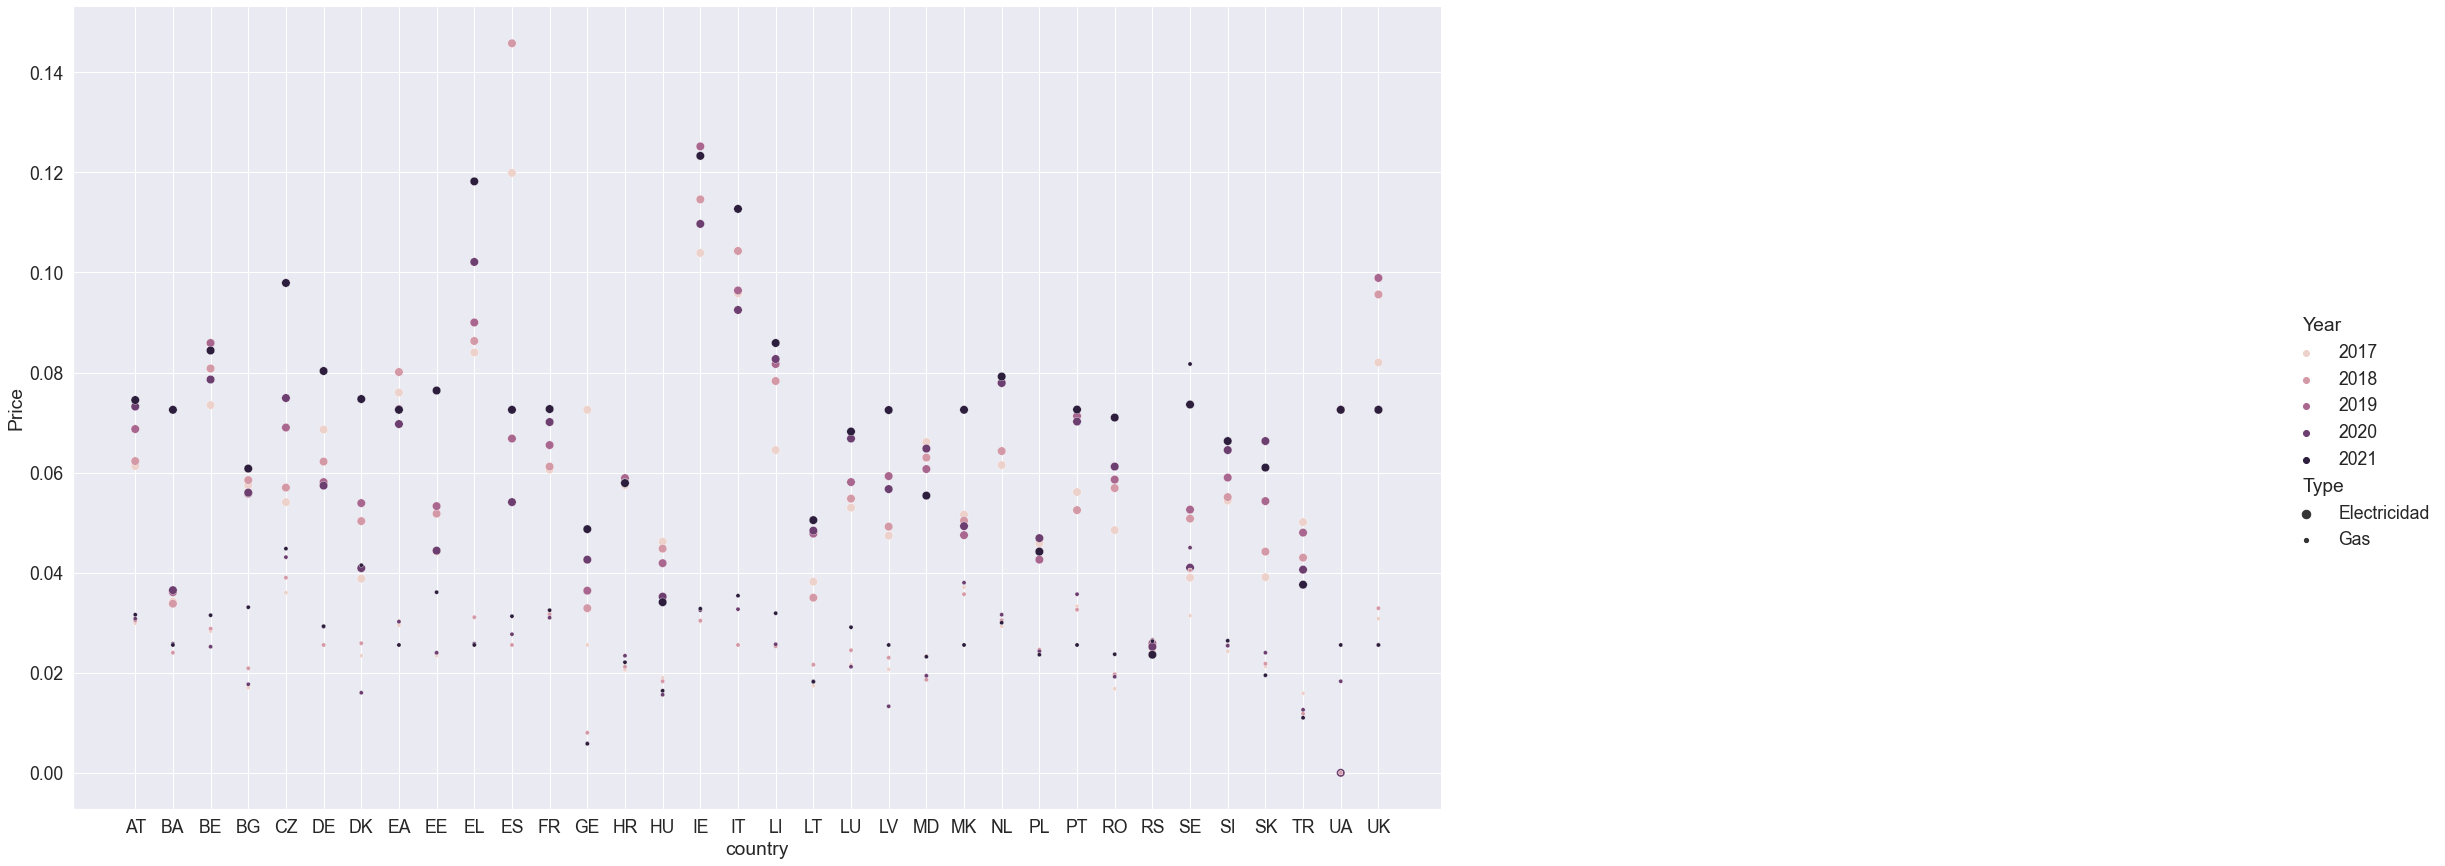

In [391]:
dEnergyHouseElect=dEnergyHouse[(dEnergyHouse['Type'] == 'Electricidad') ]
dEnergyHouseGas=dEnergyHouse[(dEnergyHouse['Type'] == 'Gas') ]


sns.set(font_scale = 1.60)
g=sns.relplot(data=dEnergyHouse, x='country', y='Price', size='Type', hue="Year")
g.fig.set_size_inches(45,15)